In [48]:
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns

In [61]:
data_fp = '/bsuhome/zacharykeskinen/spicy-snow/data/res_ds_iter_large.nc'

ds = xr.open_dataset(data_fp)

<xarray.DataArray 'mae' ()>
array(0.87890495)
Coordinates:
    location  <U28 'Little_Cottonwood_2021-03-18'
<xarray.DataArray 'mae' ()>
array(0.69040989)
Coordinates:
    location  <U28 'Mores_2021-03-15'
<xarray.DataArray 'mae' ()>
array(0.65403371)
Coordinates:
    location  <U28 'Frasier_2020-02-11'
<xarray.DataArray 'mae' ()>
array(0.73870465)
Coordinates:
    location  <U28 'Banner_2020-02-18'
<xarray.DataArray 'mae' ()>
array(0.58172155)
Coordinates:
    location  <U28 'Banner_2021-03-15'
<xarray.DataArray 'mae' ()>
array(0.54292543)
Coordinates:
    location  <U28 'Dry_Creek_2020-02-19'


/tmp/ipykernel_14543/632119590.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_14543/632119590.py:76: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


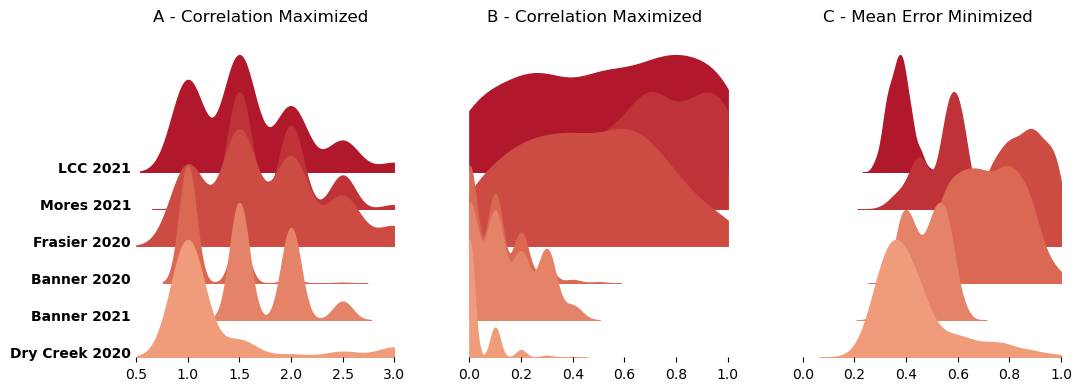

In [70]:
import matplotlib.gridspec as grid_spec
from matplotlib import colormaps
cmap = colormaps.get_cmap('RdBu')
colors = cmap(np.linspace(0.1, 0.4, len(ds.location)))

fig = plt.figure(layout='constrained', figsize=(10, 4))
subfigs = fig.subfigures(1, 3, wspace=0.07)
params = ['A', 'B', 'C']

# sorted = ds.reindex(location = ds['pearsonr'].isel(ds['pearsonr'].argmin(['A', 'C'])).idxmin('B').mean('iteration').to_dataframe().sort_values('B').to_xarray().location[::-1])

loc_sorted = ['Little_Cottonwood_2021-03-18', 'Mores_2021-03-15',\
       'Frasier_2020-02-11', 'Banner_2020-02-18', 'Banner_2021-03-15',\
       'Dry_Creek_2020-02-19']  #, 'Cameron_2021-03-19', 'Frasier_2021-03-19'  'Mores_2020-02-09'

sorted = ds.reindex(location = loc_sorted)

clips = [[0.5, 3], [0, 1], [0, 1]]

param_stat = {'A':'pearsonr', 'B':'pearsonr', 'C':'mae'}

for i, (param, subfig, clip,) in enumerate(zip(params, subfigs, clips)):
    axes = subfig.subplots(len(sorted.location), gridspec_kw = {'hspace': -0.7})
    other_params = params[:]
    other_params.remove(param)

    stat_name = param_stat[param]

    for loc, color, ax in zip(sorted.location, colors, axes):

        param_fp = Path('/bsuhome/zacharykeskinen/scratch/param_regional')
        lidar_orig = np.load(param_fp.joinpath(str(loc.data), 'lidar.npy'))
        
        param_1, param_2 = other_params
        a = sorted.loc[{param_1 : sorted[param_stat[param_1]].idxmax(param_1)}]
        if param_2 == 'C':
            data = a.loc[{param_2 : a[param_stat[param_2]].idxmin(param_2)}]
        else:
            data = a.loc[{param_2 : a[param_stat[param_2]].idxmax(param_2)}]
        
        if param == 'C':
            print(data.sel(location = loc)['mae'].min())
            data = data.idxmin(param)
        else:
            data = data.idxmax(param)
        
        data = data.sel(location = loc)
        
        data = data[param_stat[param]].data
        # data = data + np.random.random(data.shape)/1000

        sns.kdeplot(data, color = color, \
                    fill = True, alpha = 1.0, ax= ax, clip = clip, warn_singular=False, zorder = 1)
        ax.set_xlim(clip)
        ax.set_yticks([])
        ax.set_ylabel('')

        rect = ax.patch
        rect.set_alpha(0)

        spines = ["top", "right", "left", "bottom"]
        for s in spines:
            ax.spines[s].set_visible(False)
        
        if i == 0:
            site_name = str(loc.data).replace('_', ' ').replace('Little Cottonwood', 'LCC').split('-')[0]
            ax.text(-0.02, 0, site_name, fontweight = 'bold', ha = 'right', transform = ax.transAxes, zorder = 1e5)


    for ax in axes[:-1]:
        ax.set_xticks([])

    stat_title= {'mae':'Mean Error Minimized', 'pearsonr':'Correlation Maximized'}
    subfig.suptitle(f'{param} - {stat_title[param_stat[param]]}')

plt.tight_layout()

/tmp/ipykernel_14543/3186408421.py:130: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


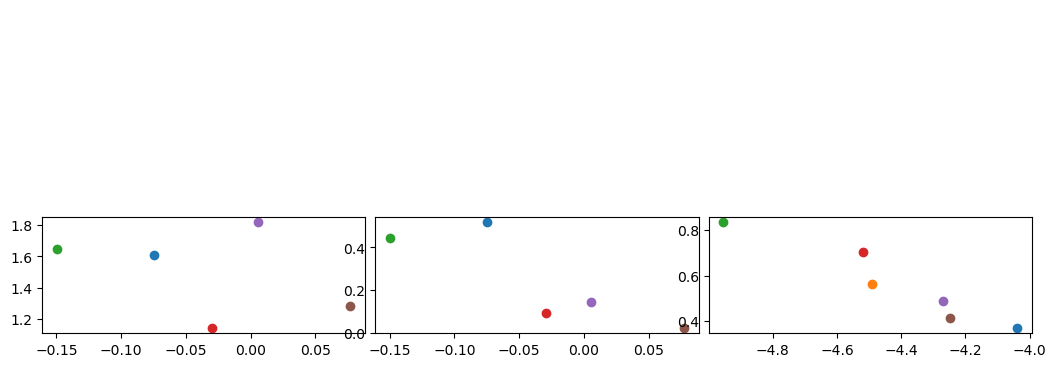

In [63]:
import matplotlib.gridspec as grid_spec
from matplotlib import colormaps
cmap = colormaps.get_cmap('RdBu')
colors = cmap(np.linspace(0.1, 0.4, len(ds.location)))

fig = plt.figure(layout='constrained', figsize=(10, 4))
subfigs = fig.subfigures(2, 3, wspace=0.07)
params = ['A', 'B', 'C']

# sorted = ds.reindex(location = ds['pearsonr'].isel(ds['pearsonr'].argmin(['A', 'C'])).idxmin('B').mean('iteration').to_dataframe().sort_values('B').to_xarray().location[::-1])

loc_sorted = ['Little_Cottonwood_2021-03-18', 'Mores_2021-03-15',\
       'Frasier_2020-02-11', 'Banner_2020-02-18', 'Banner_2021-03-15',\
       'Dry_Creek_2020-02-19'] #'Cameron_2021-03-19', 'Frasier_2021-03-19'  'Mores_2020-02-09',

sorted = ds.reindex(location = loc_sorted)
sorted = sorted.isel(iteration = slice(50))

clips = [[1, 3], [0, 1], [0, 1]]

param_stat = {'A':'pearsonr', 'B':'pearsonr', 'C':'mae'}

# for i, (param, subfig, clip,) in enumerate(zip(params, subfigs[0, :], clips)):
#     axes = subfig.subplots(len(ds.location), gridspec_kw = {'hspace': -0.7})
#     other_params = params[:]
#     other_params.remove(param)

#     stat_name = param_stat[param]

#     for loc, color, ax in zip(sorted.location, colors, axes):

#         param_fp = Path('/bsuhome/zacharykeskinen/scratch/param_regional')
#         lidar_orig = np.load(param_fp.joinpath(str(loc.data), 'lidar.npy'))
        
#         param_1, param_2 = other_params
#         a = sorted.loc[{param_1 : sorted[param_stat[param_1]].idxmax(param_1)}]
#         if param_2 == 'C':
#             data = a.loc[{param_2 : a[param_stat[param_2]].idxmin(param_2)}]
#         else:
#             data = a.loc[{param_2 : a[param_stat[param_2]].idxmax(param_2)}]
        
#         if param == 'C':
#             data = data.idxmin(param)
#         else:
#             data = data.idxmax(param)
        
#         data = data.sel(location = loc)
        
#         data = data[param_stat[param]].data
#         # data = data + np.random.random(data.shape)/1000

#         sns.kdeplot(data, color = color, \
#                     fill = True, alpha = 1.0, ax= ax, clip = clip, warn_singular=False, zorder = 1)
#         ax.set_xlim(clip)
#         ax.set_yticks([])
#         ax.set_ylabel('')

#         rect = ax.patch
#         rect.set_alpha(0)

#         spines = ["top", "right", "left", "bottom"]
#         for s in spines:
#             ax.spines[s].set_visible(False)
        
#         if i == 0:
#             site_name = str(loc.data).replace('_', ' ').replace('Little Cottonwood', 'LCC').split('-')[0]
#             ax.text(-0.02, 0, site_name, fontweight = 'bold', ha = 'right', transform = ax.transAxes, zorder = 1e5)


#     for ax in axes[:-1]:
#         ax.set_xticks([])

#     stat_title= {'mae':'Mean Error Minimized', 'pearsonr':'Correlation Maximized'}
#     subfig.suptitle(f'{param} - {stat_title[param_stat[param]]}')


for i, (subfig, param) in enumerate(zip(subfigs[1, :], params)):

    ax = subfig.subplots(1, 1)
    other_params = params[:]
    other_params.remove(param)

    for loc in sorted.location:

        ds_fp = Path('/bsuhome/zacharykeskinen/scratch/SnowEx-Data')
        full_ds = xr.load_dataset(ds_fp.joinpath(str(loc.data)+'.nc'))
        
        param_1, param_2 = other_params
        a = sorted.loc[{param_1 : sorted[param_stat[param_1]].idxmax(param_1)}]
        if param_2 == 'C':
            data = a.loc[{param_2 : a[param_stat[param_2]].idxmin(param_2)}]
        else:
            data = a.loc[{param_2 : a[param_stat[param_2]].idxmax(param_2)}]
        
        if param == 'C':
            data = data.idxmin(param)
        else:
            data = data.idxmax(param)
        
        data = data.sel(location = loc)
        
        data = data[param_stat[param]].data

        if param == 'C':
            CR = full_ds['s1'].sel(band = 'VH') - full_ds['s1'].sel(band = 'VV')
            x = CR.max('time').mean()
            # x = full_ds['deltaGamma'].max('time').mean()
            # x = full_ds['s1'].sel(band = 'VV').max('time').mean()
        else:
            trees = full_ds.where(full_ds['fcf'] > 0.5)
            x = (full_ds['deltaVV'].mean('time') / full_ds['lidar-sd']).mean()
            # y = trees['deltaVV'].mean(dim = 'time')
            # x = (y / (trees['fcf'] + 0.01)).mean()
            # x = full_ds['s1'].sel(band = 'VV').max('time')# / full_ds['fcf'] # / full_ds['deltaCR']
            # s1 = full_ds['s1']
            # trees = full_ds.where(full_ds['fcf'] > 0.5)
            # x = full_ds['s1'].sel(band = 'VH').diff('time').mean('time') / (full_ds['fcf'] + 1)
            # x = xr.where(x > 1000, np.nan, x)
            # x = xr.where(x > -1000, x, np.nan)
            # x = trees['deltaCR'] / trees['deltaVV']
            # CR = full_ds['s1'].sel(band = 'VH') - full_ds['s1'].sel(band = 'VV')
            # x = full_ds['fcf']
            # x = x.mean()
            # if x < -0.5:
            #     print(loc)
            #     x = np.nan
            
        ax.scatter(x, np.mean(data), label = loc)
    # plt.legend()
plt.tight_layout()

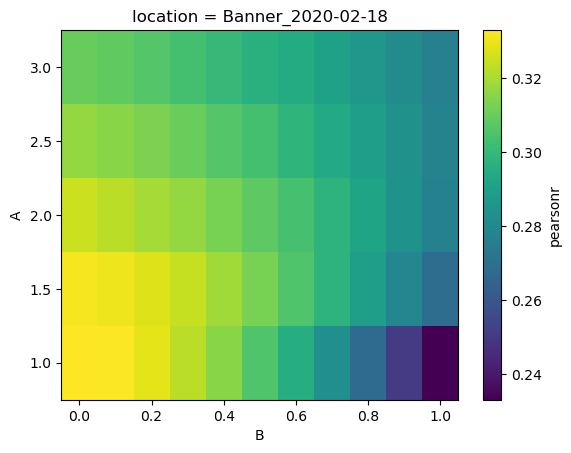

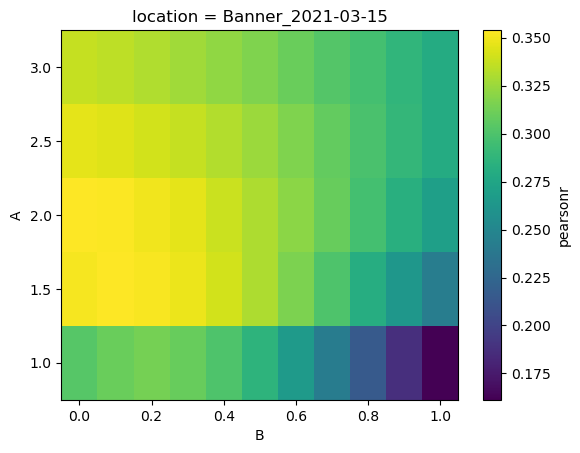

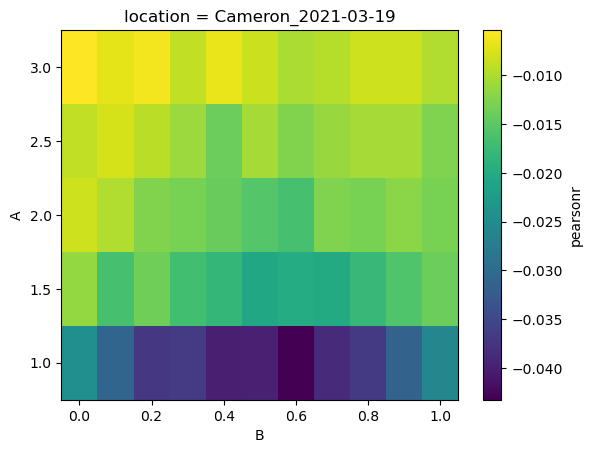

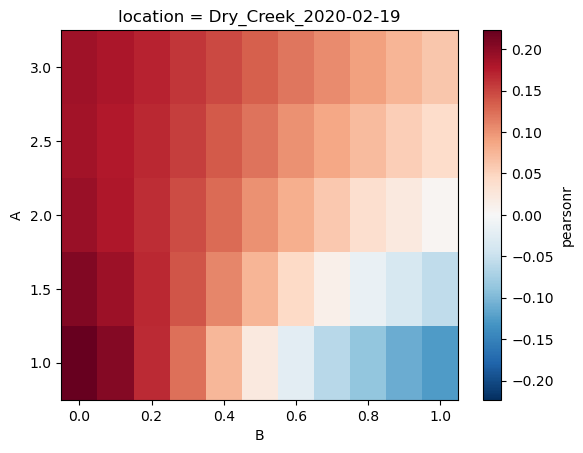

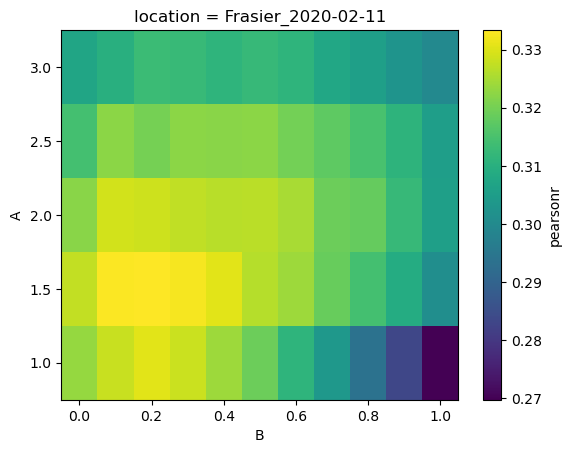

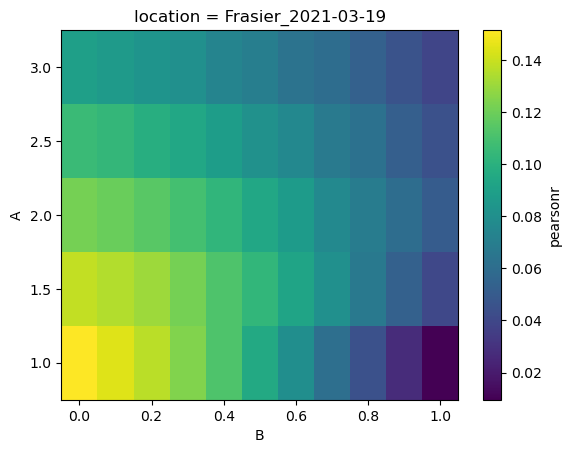

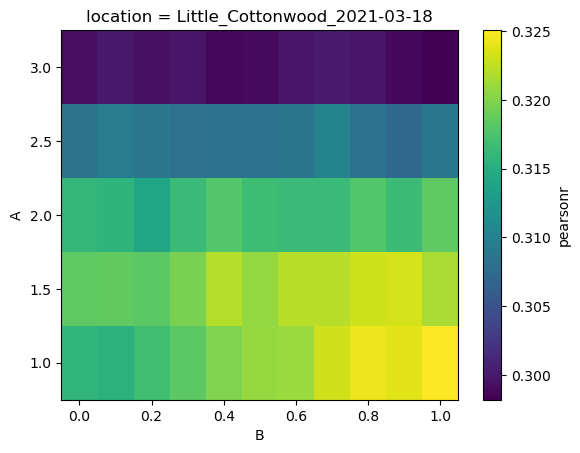

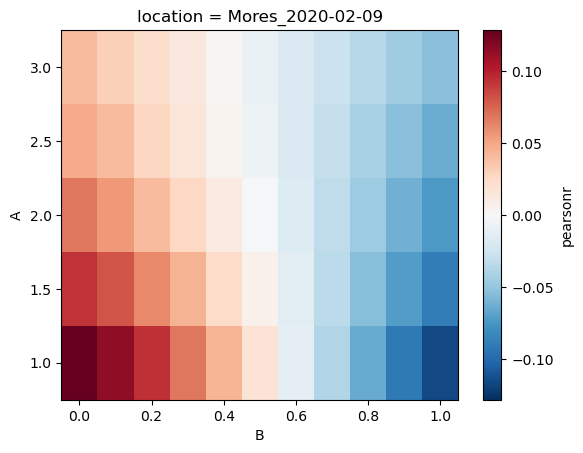

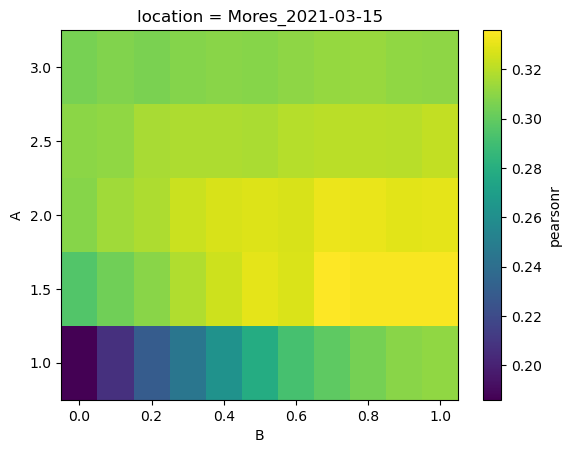

In [67]:
params = ['A', 'B', 'C']

loc_sorted = [ 'Cameron_2021-03-19','Little_Cottonwood_2021-03-18', 'Mores_2020-02-09', 'Mores_2021-03-15',\
       'Frasier_2020-02-11', 'Frasier_2021-03-19', 'Banner_2020-02-18', 'Banner_2021-03-15',\
       'Dry_Creek_2020-02-19']
sorted = ds.reindex(location = loc_sorted)

best_c = sorted.loc[{'C' : sorted['mae'].idxmin('C')}]
best_c = best_c.mean('iteration')
for loc, sub_ds in best_c.groupby('location'):
       sub_ds['pearsonr'].plot()
       plt.show()

In [71]:
files = Path('/bsuhome/zacharykeskinen/spicy-snow/Lidar_s1_stacks/').glob('*.nc')

In [125]:
import py3dep
import rioxarray as rxa
files = Path('/bsuhome/zacharykeskinen/spicy-snow/SnowEx-Data').glob('*.nc')
for fp in files:
    ds = xr.load_dataset(fp)
    dem = py3dep.get_dem(ds.rio.bounds(), 30)
    ds['dem'] = dem.drop(['band', 'spatial_ref']).interp_like(ds)
    ds = ds.drop('lidar-dem')
    ds.to_netcdf(fp.with_suffix('.fix.nc'))


ValueError: These variables cannot be found in this dataset: ['lidar-dem']

In [124]:
ds.drop('lidar-dem')

<xarray.Dataset>
Dimensions:         (y: 75, x: 98, time: 77)
Coordinates:
  * x               (x) float64 -115.7 -115.7 -115.7 ... -115.6 -115.6 -115.6
  * y               (y) float64 43.98 43.98 43.98 43.98 ... 43.91 43.91 43.91
  * time            (time) datetime64[ns] 2020-08-03T13:49:39 ... 2021-03-27T...
    flight_dir      (time) object 'descending' 'ascending' ... 'ascending'
    platform        (time) object 'S1A' 'S1A' 'S1B' 'S1B' ... 'S1A' 'S1B' 'S1B'
    relative_orbit  (time) float64 71.0 93.0 71.0 93.0 ... 71.0 93.0 71.0 93.0
    absolute_orbit  (time) float64 3.374e+04 3.376e+04 ... 2.617e+04 2.619e+04
    projection      int64 0
Data variables:
    lidar-sd        (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    lidar-vh        (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    snow_depth      (y, x, time) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    wet_snow        (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    spatial_ref     int64 0
    dem             (y, x) float64 dask.array<chunksize=(75, 98), meta=np.ndarray>
Attributes: (12/15)
    AREA_OR_POINT:      Point
    TIFFTAG_DATETIME:   2023:05:19 06:13:47
    TIFFTAG_SOFTWARE:   Created with GAMMA Software www.gamma-rs.ch data2geot...
    scale_factor:       1.0
    add_offset:         0.0
    resolution:         90
    ...                 ...
    param_C:            0.55
    job_name:           spicy_USIDMC_2021-03-29
    bounds:             [-115.73523191   43.90718932 -115.63547268   43.98397...
    site:               Mores
    site_abbrev:        USIDMC
    lidar-flight-time:  2021-03-15

In [122]:
fp.with_suffix('.fix.nc')

PosixPath('/bsuhome/zacharykeskinen/spicy-snow/SnowEx-Data/Mores_2021-03-15.sub.fix.nc')

In [91]:
dem = py3dep.get_dem(ds.rio.bounds(), 30)

In [111]:
ds['dem'] = dem.drop(['band', 'spatial_ref']).interp_like(ds)

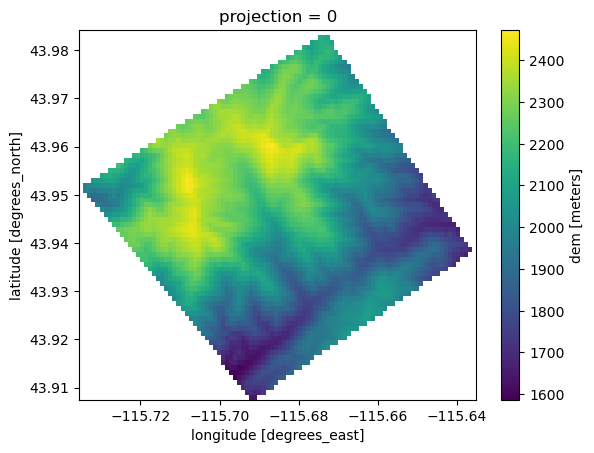

In [120]:
ds.where(~ds['lidar-sd'].isnull())['dem'].plot()

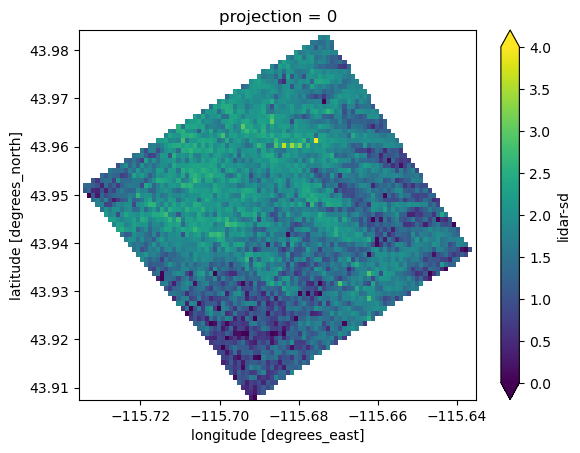

In [119]:
ds['lidar-sd'].plot(vmin = 0, vmax = 4)

In [110]:
dem.drop(['band', 'spatial_ref']).interp_like(ds)

<xarray.DataArray 'elevation' (y: 75, x: 98)>
dask.array<transpose, shape=(75, 98), dtype=float64, chunksize=(75, 98), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 -115.7 -115.7 -115.7 -115.7 ... -115.6 -115.6 -115.6
  * y        (y) float64 43.98 43.98 43.98 43.98 ... 43.91 43.91 43.91 43.91
Attributes:
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        3646.8061523438
    STATISTICS_MEAN:           471.43747096987
    STATISTICS_MINIMUM:        -8.4350395202637
    STATISTICS_STDDEV:         571.85377663773
    STATISTICS_VALID_PERCENT:  11.02
    scale_factor:              1.0
    add_offset:                0.0
    _FillValue:                nan
    units:                     meters
    vertical_datum:            NAVD88
    vertical_resolution:       0.001